# initial code

In [ ]:
# microbiome_hysteresis_lit.py
# ---------------------------------------------------------------
# Host–microbe–butyrate ODE model with a memory-like regulator
# to produce hysteresis. Parameters are grounded to literature
# magnitudes (see inline comments and manuscript text).
#
# Outputs:
#   - out_baseline_timeseries.png
#   - out_hysteresis_H_vs_d.png
#   - out_hysteresis_q_vs_d.png
#   - out_hysteresis_summary.csv
#   - out_EWI_slow_ramp.png
#   - out_EWI_slow_ramp.csv
#   - out_phase_plane_HB.png
#   - out_steady_state_stability.csv
#
# Requirements: numpy, scipy, matplotlib, pandas
# ---------------------------------------------------------------

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from numpy.linalg import eigvals
import matplotlib.pyplot as plt


In [ ]:
# ------------------ 0) Units and scaling ------------------
# We track "relative" abundances/health in [0,1].
# For butyrate B we allow a soft mapping to mM via B_scale.
# Typical colonic butyrate is ~10–25 mM (order of magnitude). We pick 20 mM as a scale.
# (Fagundes 2024; Parada Venegas 2019)  [see write-up for citations]
B_scale_mM = 20.0    # 1 model unit of B ~ 20 mM

In [ ]:
# ------------------ 1) Parameters (literature-anchored) ------------------
# Microbe (representative butyrogen like F. prausnitzii)
# In vitro growth ~0.32 h^-1 reported on M2G medium (Heinken 2014).
r_max = 0.32         # 1/hr
K_M   = 1.0          # carrying cap (relative units)

# Cost of butyrate production on growth (phenomenological)
# Choose c so that even at high production p_high, net growth remains positive:
# r_max - c * p_high > 0. With p_high=2.5, pick c=0.10 -> 0.32 - 0.25 = +0.07
c     = 0.10

# Host (consumer)
K_H   = 1.0
g     = 0.5          # health gain from butyrate (scaled)
# Colonocytes absorb ~95% of luminal butyrate; turnover timescale O(hours),
# so u ~ 0.4–0.8 h^-1 is reasonable at H ~ O(1), giving 1–2 h half-life.
# (Salvi & Cowles 2021; Güler 2025 review)
u     = 0.6          # butyrate uptake by host

# Inflammation/decay parameter (control knob for sweeps)
d_base = 0.12        # 1/hr (we will sweep around this)

# Production levels and hysteresis thresholds
p_low, p_high = 0.1, 2.5
H_on, H_off   = 0.55, 0.70    # lower/upper thresholds (hysteresis band)
tau_q         = 4.0           # hours (memory timescale)

In [ ]:
# ------------------ 2) Core dynamics ------------------

def p_B_dynamic(y, H_min=0.6):
    """Original reactive strategy (for reference)."""
    M, H, B = y[:3]
    return 2.5 if H < H_min else 0.1

def p_B_fixed(y, p_constant=1.8):
    return p_constant

def microbiome_model(t, y, p_B_func, params):
    """3D system: y=[M,H,B] (reference model)"""
    M, H, B = y
    r_max, K_M, c, d, K_H, g, u = params
    p_B = p_B_func(y)
    dMdt = (r_max - c * p_B) * M * (1 - M / K_M)
    dHdt = g * B * (1 - H / K_H) - d * H
    dBdt = p_B * M - u * H * B
    return [dMdt, dHdt, dBdt]

def microbiome_model_mem(t, y, params):
    """
    4D system with hysteretic regulator q in [0,1]:
    y = [M, H, B, q]
    p_B = p_low + (p_high - p_low) * q
    q tends toward 1 when H < H_on, toward 0 when H > H_off, and "holds" in between.
    """
    M, H, B, q = y
    (r_max, K_M, c, d, K_H, g, u,
     p_low, p_high, H_on, H_off, tau_q) = params

    p_B = p_low + (p_high - p_low) * np.clip(q, 0.0, 1.0)

    dMdt = (r_max - c * p_B) * M * (1 - M / K_M)
    dHdt = g * B * (1 - H / K_H) - d * H
    dBdt = p_B * M - u * H * B

    if H < H_on:
        q_inf = 1.0
    elif H > H_off:
        q_inf = 0.0
    else:
        q_inf = q  # hold

    dqdt = (q_inf - q) / tau_q
    return [dMdt, dHdt, dBdt, dqdt]

# Convenience pack
def pack_params(d_value):
    return (r_max, K_M, c, d_value, K_H, g, u, p_low, p_high, H_on, H_off, tau_q)

In [ ]:
# ------------------ 3) Baseline simulation ------------------
def run_baseline(d_value=d_base, T=48, y0=[0.1, 0.9, 0.0, 0.0]):
    params = pack_params(d_value)
    t_eval = np.linspace(0, T, 400)
    sol = solve_ivp(microbiome_model_mem, (0, T), y0, args=(params,),
                    method="RK45", t_eval=t_eval)
    # Plot
    fig, ax = plt.subplots(3, 1, figsize=(9, 10), sharex=True)
    ax[0].plot(sol.t, sol.y[0]); ax[0].set_ylabel("M")
    ax[1].plot(sol.t, sol.y[1]); ax[1].axhline(H_on, ls=":", c="k")
    ax[1].axhline(H_off, ls="--", c="k"); ax[1].set_ylabel("H")
    ax[2].plot(sol.t, sol.y[2]); ax[2].set_ylabel("B (≈ mM/{:g})".format(B_scale_mM))
    ax[2].set_xlabel("Time (hr)")
    for a in ax: a.grid(True, ls=":", alpha=0.6)
    plt.suptitle("Baseline dynamics (d = {:.2f})".format(d_value))
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.savefig("out_baseline_timeseries.png", dpi=200)
    return sol

In [ ]:
# ------------------ 4) Hysteresis sweep ------------------
def simulate_to_ss(d_value, y_init, t_final=140):
    sol = solve_ivp(microbiome_model_mem, (0, t_final), y_init,
                    args=(pack_params(d_value),),
                    method="RK45", rtol=1e-6, atol=1e-8, max_step=0.5)
    return sol.y[:, -1], sol

def hysteresis_sweep(d_lo=0.06, d_hi=0.28, n=18, y0=np.array([0.1,0.9,0.0,0.0]), t_final=140):
    d_forward = np.linspace(d_lo, d_hi, n)
    d_backward = d_forward[::-1]

    y = y0.copy()
    f_rows = []
    for d in d_forward:
        y, _ = simulate_to_ss(d, y, t_final)
        f_rows.append({"d": d, "M": y[0], "H": y[1], "B": y[2], "q": y[3]})
    df_fwd = pd.DataFrame(f_rows)

    b_rows = []
    for d in d_backward:
        y, _ = simulate_to_ss(d, y, t_final)
        b_rows.append({"d": d, "M": y[0], "H": y[1], "B": y[2], "q": y[3]})
    df_bwd = pd.DataFrame(b_rows)

    # Plots
    plt.figure(figsize=(7,5))
    plt.plot(df_fwd["d"], df_fwd["H"], marker="o", label="Forward (d ↑)")
    plt.plot(df_bwd["d"], df_bwd["H"], marker="s", label="Backward (d ↓)")
    plt.xlabel("Inflammation/decay rate d (1/hr)")
    plt.ylabel("Steady-state Host Health H*")
    plt.title("Hysteresis in H* vs d")
    plt.legend(); plt.grid(True, ls=":", alpha=0.6); plt.tight_layout()
    plt.savefig("out_hysteresis_H_vs_d.png", dpi=200)

    plt.figure(figsize=(7,5))
    plt.plot(df_fwd["d"], df_fwd["q"], marker="o", label="Forward (d ↑)")
    plt.plot(df_bwd["d"], df_bwd["q"], marker="s", label="Backward (d ↓)")
    plt.xlabel("d (1/hr)"); plt.ylabel("q*")
    plt.title("Production memory exhibits hysteresis")
    plt.legend(); plt.grid(True, ls=":", alpha=0.6); plt.tight_layout()
    plt.savefig("out_hysteresis_q_vs_d.png", dpi=200)

    # Save aligned CSV and compute H-gap
    df = pd.DataFrame({
        "d": df_fwd["d"].values,
        "H_forward": df_fwd["H"].values,
        "H_backward": df_bwd.sort_values("d")["H"].values,
        "q_forward": df_fwd["q"].values,
        "q_backward": df_bwd.sort_values("d")["q"].values
    })
    df["H_gap"] = df["H_forward"] - df["H_backward"]
    df.to_csv("out_hysteresis_summary.csv", index=False)

    return df_fwd, df_bwd, df

In [ ]:
# ------------------ 5) Early-warning indicators during slow ramp ------------------
def simulate_slow_ramp(y0=np.array([0.2,0.85,0.05,0.0]),
                       d_start=0.08, d_end=0.25, T=600, dt=0.5,
                       sigma=0.002, seed=7):
    rng = np.random.default_rng(seed)
    times = np.arange(0, T+dt, dt)
    d_path = np.linspace(d_start, d_end, len(times))
    y = y0.copy()

    rec = []
    for i, t in enumerate(times[:-1]):
        d = d_path[i]
        params = pack_params(d)
        # Heun's method (RK2) with small dt
        k1 = np.array(microbiome_model_mem(t, y, params))
        k2 = np.array(microbiome_model_mem(t+dt, y+dt*k1, params))
        y = y + 0.5*dt*(k1+k2)
        # stochastic perturbation of H (measurement/phys noise)
        y[1] += sigma * rng.normal()
        rec.append((times[i+1], d_path[i+1], *y))
    arr = np.array(rec)
    df = pd.DataFrame(arr, columns=["t","d","M","H","B","q"])

    # Rolling variance and lag-1 AC (critical slowing down indicators)
    w = 40  # window ~20 hr at dt=0.5
    df["H_var"] = df["H"].rolling(w).var()
    def ac1(x):
        if len(x)<2: return np.nan
        return float(np.corrcoef(x[:-1], x[1:])[0,1])
    df["H_ac1"] = df["H"].rolling(w).apply(ac1, raw=False)

    fig, ax = plt.subplots(3,1, figsize=(8,9), sharex=True)
    ax[0].plot(df["t"], df["H"]); ax[0].axhline(H_on, ls=":", c="k"); ax[0].axhline(H_off, ls="--", c="k")
    ax[0].set_ylabel("H"); ax[0].set_title("Slow ramp of d with noise")
    ax[1].plot(df["t"], df["H_var"]); ax[1].set_ylabel("Var[H] (rolling)")
    ax[2].plot(df["t"], df["H_ac1"]); ax[2].set_ylabel("AC1[H] (rolling)"); ax[2].set_xlabel("Time (hr)")
    for a in ax: a.grid(True, ls=":", alpha=0.6)
    plt.tight_layout(); fig.savefig("out_EWI_slow_ramp.png", dpi=200)
    df.to_csv("out_EWI_slow_ramp.csv", index=False)
    return df

In [ ]:
# ------------------ 6) Phase-plane snapshot (H,B) ------------------
def phase_plane(M_ss=0.9, q_ss=0.3, d=0.16):
    p_B = p_low + (p_high - p_low) * q_ss
    H_vals = np.linspace(0, 1.05, 200)
    B_vals = np.linspace(0, 1.05, 200)
    Hg, Bg = np.meshgrid(H_vals, B_vals)
    dH = g*Bg*(1 - Hg/K_H) - d*Hg
    dB = p_B*M_ss - u*Hg*Bg

    plt.figure(figsize=(6.5,5.5))
    cs1 = plt.contour(Hg, Bg, dH, levels=[0], linewidths=2)
    cs2 = plt.contour(Hg, Bg, dB, levels=[0], linewidths=2, linestyles="--")
    plt.clabel(cs1, fmt={"0":"dH=0"}); plt.clabel(cs2, fmt={"0":"dB=0"})
    plt.xlabel("H"); plt.ylabel("B (≈ mM/{:g})".format(B_scale_mM))
    plt.title("Phase-plane (H,B) nullclines (M,q fixed)")
    plt.grid(True, ls=":", alpha=0.6); plt.tight_layout()
    plt.savefig("out_phase_plane_HB.png", dpi=200)

In [ ]:
# ------------------ 7) Local stability (numeric Jacobian) ------------------
def numeric_jacobian(f, y, params, eps=1e-6):
    y = np.array(y, dtype=float)
    n = len(y)
    f0 = np.array(f(0.0, y, params))
    J = np.zeros((n,n))
    for j in range(n):
        y2 = y.copy(); y2[j] += eps
        f1 = np.array(f(0.0, y2, params))
        J[:,j] = (f1 - f0)/eps
    return J

def steady_state_and_stability(d_value, y_guess, t_relax=200):
    # relax to steady state
    y_end, _ = simulate_to_ss(d_value, y_guess, t_relax)
    # Jacobian eigenvalues
    J = numeric_jacobian(microbiome_model_mem, y_end, pack_params(d_value))
    lam = eigvals(J)
    return y_end, lam


In [ ]:
# ------------------ 8) Main ------------------
if __name__ == "__main__":
    # (A) Baseline
    run_baseline(d_base)

    # (B) Hysteresis sweeps
    df_fwd, df_bwd, df_gap = hysteresis_sweep()

    # (C) Early-warning indicators (slow ramp)
    df_ewi = simulate_slow_ramp()

    # (D) Phase-plane illustration
    phase_plane(M_ss=0.95, q_ss=0.3, d=0.16)

    # (E) Stability at a few d values along forward/backward branches
    rows = []
    for d_probe in [0.10, 0.16, 0.22]:
        # forward branch initial guess
        y_guess = np.array([0.5, 0.7, 0.3, 0.1])
        y_ss, lam = steady_state_and_stability(d_probe, y_guess)
        rows.append({"branch":"forward_like", "d":d_probe,
                     "M":y_ss[0], "H":y_ss[1], "B":y_ss[2], "q":y_ss[3],
                     "max_Re_lambda": float(np.max(np.real(lam)))})
        # backward branch initial guess
        y_guess = np.array([0.9, 0.6, 0.25, 0.8])
        y_ss, lam = steady_state_and_stability(d_probe, y_guess)
        rows.append({"branch":"backward_like", "d":d_probe,
                     "M":y_ss[0], "H":y_ss[1], "B":y_ss[2], "q":y_ss[3],
                     "max_Re_lambda": float(np.max(np.real(lam)))})
    pd.DataFrame(rows).to_csv("out_steady_state_stability.csv", index=False)

    print("Done. Files written:")
    print("  - out_baseline_timeseries.png")
    print("  - out_hysteresis_H_vs_d.png")
    print("  - out_hysteresis_q_vs_d.png")
    print("  - out_hysteresis_summary.csv")
    print("  - out_EWI_slow_ramp.png")
    print("  - out_EWI_slow_ramp.csv")
    print("  - out_phase_plane_HB.png")
    print("  - out_steady_state_stability.csv")


# time-series metabolomics

In [ ]:
import os
os.getcwd()


In [ ]:
# === Build SCFA-wide table from subjects/samples + metabolite matrix + metadata (raw + scored) ===
# Output:
#   combined_scfas_table_raw.csv    → full text responses beside metabolites
#   combined_scfas_table_scored.csv → numeric/normalized features
# -------------------------------------------------------------------
import pandas as pd, numpy as np, re, os
from pathlib import Path
from datetime import datetime

# ---- Input/Output paths ----
SUBJECTS_FILE = Path("timeseries/metabolomics_subject_samples.csv")
METAB_FILE    = Path("timeseries/metabolomics_samples.csv")
OUT_DIR       = Path("timeseries")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_RAW       = OUT_DIR / "combined_scfas_table_raw.csv"
OUT_SCORED    = OUT_DIR / "combined_scfas_table_scored.csv"

# -------------------------------------------------------------------
# Basic helpers
# -------------------------------------------------------------------
def detect_col(df, candidates):
    cl = {c.lower(): c for c in df.columns}
    for k in candidates:
        if k.lower() in cl: return cl[k.lower()]
    return None

def norm_key(s): return re.sub(r'[\s\-_/]', '', str(s).strip().lower())

def parse_date_loose(s):
    if not s or pd.isna(s): return np.nan
    s = str(s).strip()
    fmts = ["%m/%d/%Y","%m/%d/%y","%Y-%m-%d","%d/%m/%Y","%d-%m-%Y","%Y.%m.%d"]
    for fmt in fmts:
        try: return datetime.strptime(s, fmt).date().isoformat()
        except Exception: pass
    return s

# -------------------------------------------------------------------
# 1) Read subject-sample metadata
# -------------------------------------------------------------------
df_subj = pd.read_csv(SUBJECTS_FILE)
subject_col = detect_col(df_subj, ["Subject_ID","Subject","Participant_ID","patient_id","subject id"])
sample_col  = detect_col(df_subj, ["Sample_ID","Sample","local_sample_id","Sample name","SM_ID","SM"])
details_col = detect_col(df_subj, ["Details","detail","notes","metadata"])
if sample_col is None:
    for c in df_subj.columns:
        if any(str(v).startswith("SM-") for v in df_subj[c].astype(str).head(50)):
            sample_col = c; break

# -------------------------------------------------------------------
# 2) Parse full metadata string into dict of raw values
# -------------------------------------------------------------------
def parse_metadata_string(meta_str):
    s = re.sub(r"\|", ";", str(meta_str))
    s = re.sub(r"\s*;\s*", ";", s)
    pairs = re.split(r";\s*", s.strip())
    out = {}
    for p in pairs:
        if "=" in p: k,v = p.split("=",1)
        elif ":" in p: k,v = p.split(":",1)
        else: continue
        out[k.strip()] = v.strip()
    return out

parsed_meta = df_subj.get(details_col, pd.Series([""]*len(df_subj))).map(parse_metadata_string)
raw_df = pd.json_normalize(parsed_meta).fillna("")

# -------------------------------------------------------------------
# 3) Extract numeric/scored features
# -------------------------------------------------------------------
freq_map = {
    "No, I did not consume": 0.0,
    "Within the past 4 to 7 days": 0.25,
    "Within the past 2 to 3 days": 0.5,
    "Yesterday, 1 to 2 times": 0.75,
    "Yesterday, 3 or more times": 1.0,
    "Yesterday": 0.75
}
wellbeing_map = {"Well": 1.0, "Slightly below par": 0.8, "Poor": 0.4, "Very poor": 0.2}
yn_map = {"Yes": 1, "No": 0, "-": np.nan}

def extract_features(meta_dict):
    feat = {}
    # demographics
    try: feat["Age"] = float(meta_dict.get("Age", np.nan))
    except: feat["Age"] = np.nan
    feat["Sex_Female"] = 1 if "Female" in meta_dict.get("sex","") else 0
    feat["Wellbeing"] = wellbeing_map.get(meta_dict.get("General wellbeing",""), np.nan)
    # inflammation
    for k in ["HBI","Fecal Calprotectin"]:
        v = meta_dict.get(k,"")
        if re.search(r'[0-9]',v):
            feat[k.replace(" ","_")] = float(re.findall(r"[0-9.]+",v)[0])
        else:
            feat[k.replace(" ","_")] = np.nan
    # meds
    for k in ["Antibiotics","Immunosuppressants (e.g. oral corticosteroids)","Probiotic"]:
        match = [kk for kk in meta_dict if k.lower().split()[0] in kk.lower()]
        if match:
            val = meta_dict[match[0]]
            feat[k.split()[0]] = yn_map.get(val.split()[0], np.nan)
    # diet freq
    diet_vars = ["Yogurt","Dairy","Fruits","Vegetables","Beans","Whole grains",
                 "Starch","Sweets","Alcohol","Fish","White meat","Red meat"]
    for d in diet_vars:
        v = ""
        for k in meta_dict:
            if d.lower() in k.lower(): v = meta_dict[k]; break
        val = 0.0
        for kstr,sc in freq_map.items():
            if kstr in v: val = sc; break
        feat[d.replace(" ","_")+"_freq"] = val
    # derived scores
    fiber_keys = ["Fruits_freq","Vegetables_freq","Beans_freq","Whole_grains_freq","Starch_freq"]
    feat["Fiber_score"] = np.nanmean([feat.get(k,0) for k in fiber_keys])
    feat["Protein_score"] = np.nanmean([feat.get("White_meat_freq",0),
                                        feat.get("Red_meat_freq",0),
                                        feat.get("Fish_freq",0)])
    feat["Probiotic_score"] = feat.get("Yogurt_freq",0) + feat.get("Probiotic",0)
    # health proxy
    inv_hbi = 1 - np.clip((feat.get("HBI",0) or 0)/20,0,1)
    inv_fcal = 1 - np.clip((feat.get("Fecal_Calprotectin",0) or 0)/250,0,1)
    well = feat.get("Wellbeing",np.nan)
    vals = [v for v in [inv_hbi, inv_fcal, well] if not np.isnan(v)]
    feat["H_proxy_meta"] = np.nanmean(vals) if vals else np.nan
    return feat

feature_dicts = parsed_meta.map(extract_features)
scored_df = pd.json_normalize(feature_dicts)

# -------------------------------------------------------------------
# 4) Basic IDs + merge raw & scored
# -------------------------------------------------------------------
id_df = pd.DataFrame({
    "sample_id": df_subj[sample_col].astype(str),
    "subject_id": df_subj[subject_col].astype(str)
})
raw_full  = pd.concat([id_df, raw_df], axis=1)
score_full = pd.concat([id_df, scored_df], axis=1)

# -------------------------------------------------------------------
# 5) Metabolite matrix and merge with both tables
# -------------------------------------------------------------------
df_met = pd.read_csv(METAB_FILE)
met_name_col = detect_col(df_met, ["metabolite_name","metabolite","compound","name"])
sample_cols  = [c for c in df_met.columns if c.startswith("SM-")]
if met_name_col is None or not sample_cols:
    raise ValueError("Could not detect metabolite name column or any SM-* sample columns.")

df_met["_name_key"] = df_met[met_name_col].map(norm_key)
SCFA_ALIASES = {
    "acetate":{"acetate","acetic acid","aceticacid"},
    "propionate":{"propionate","propionic acid","propionicacid"},
    "butyrate":{"butyrate","butyric acid","butyricacid"},
    "isobutyrate":{"isobutyrate","2-methylpropionate","isobutyric acid","isobutyricacid"},
    "isovalerate":{"isovalerate","3-methylbutyrate","isovaleric acid","isovalericacid"},
    "valerate":{"valerate","pentanoate","valeric acid","valericacid"},
    "caproate":{"caproate","hexanoate","caproic acid","caproicacid"},
    "lactate":{"lactate"}
}
alias_to_canon = {norm_key(n):canon for canon,names in SCFA_ALIASES.items() for n in names}
df_met["scfa_label"] = df_met["_name_key"].map(alias_to_canon)
scfa_rows = df_met[df_met["scfa_label"].notna()].copy()
canonical_order = ["acetate","propionate","butyrate","isobutyrate","isovalerate","valerate","caproate"]

if len(scfa_rows)>0:
    long = scfa_rows.melt(id_vars=["scfa_label"],value_vars=sample_cols,
                          var_name="sample_id",value_name="intensity")
    wide = long.pivot_table(index="sample_id",columns="scfa_label",
                            values="intensity",aggfunc="first")
    wide = wide.reindex(columns=[c for c in canonical_order if c in wide.columns])
else:
    wide = pd.DataFrame(columns=canonical_order,index=sample_cols)
wide = wide.reset_index()

# merge
df_raw_final   = wide.merge(raw_full, on="sample_id", how="left")
df_score_final = wide.merge(score_full, on="sample_id", how="left")

# -------------------------------------------------------------------
# 6) Sort and write both
# -------------------------------------------------------------------
for df, path in [(df_raw_final, OUT_RAW), (df_score_final, OUT_SCORED)]:
    # Make sure week_number exists and is a Series
    if "week_number" in df.columns:
        wk_sort = pd.to_numeric(df["week_number"], errors="coerce").fillna(1e9)
    else:
        wk_sort = pd.Series([1e9] * len(df), index=df.index)

    df_sorted = (
        df.assign(_wk=wk_sort)
          .sort_values(["subject_id", "_wk", "sample_id"], na_position="last")
          .drop(columns=["_wk"], errors="ignore")
          .reset_index(drop=True)
    )

    df_sorted.to_csv(path, index=False)
    print(f"✅ Wrote {path} ({df_sorted.shape[1]} columns, {df_sorted.shape[0]} rows)")

print("\nFiles generated successfully:")
print(" • combined_scfas_table_raw.csv   → raw text responses + metabolites")
print(" • combined_scfas_table_scored.csv → numeric/normalized features + metabolites\n")



In [2]:
# === Build SCFA-wide table from subjects/samples + metabolite matrix + metadata (raw + scored + smoothed H_proxy) ===
# ---------------------------------------------------------------------------------------------------------------
import pandas as pd, numpy as np, re, os
from pathlib import Path
from datetime import datetime

# ---- Input/Output paths ----
SUBJECTS_FILE = Path("timeseries/metabolomics_subject_samples.csv")
METAB_FILE    = Path("timeseries/metabolomics_samples.csv")
OUT_DIR       = Path("timeseries")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_RAW       = OUT_DIR / "combined_scfas_table_raw.csv"
OUT_SCORED    = OUT_DIR / "combined_scfas_table_scored.csv"

# ---------------------------------------------------------------------------------------------------------------
# Basic helpers
# ---------------------------------------------------------------------------------------------------------------
def detect_col(df, candidates):
    cl = {c.lower(): c for c in df.columns}
    for k in candidates:
        if k.lower() in cl:
            return cl[k.lower()]
    return None

def norm_key(s):
    return re.sub(r'[\s\-_/]', '', str(s).strip().lower())

def parse_date_loose(s):
    if not s or pd.isna(s):
        return np.nan
    s = str(s).strip()
    fmts = ["%m/%d/%Y","%m/%d/%y","%Y-%m-%d","%d/%m/%Y","%d-%m-%Y","%Y.%m.%d"]
    for fmt in fmts:
        try:
            return datetime.strptime(s, fmt).date().isoformat()
        except Exception:
            pass
    return s

# ---------------------------------------------------------------------------------------------------------------
# 1) Read subject-sample metadata
# ---------------------------------------------------------------------------------------------------------------
df_subj = pd.read_csv(SUBJECTS_FILE)
subject_col = detect_col(df_subj, ["Subject_ID","Subject","Participant_ID","patient_id","subject id"])
sample_col  = detect_col(df_subj, ["Sample_ID","Sample","local_sample_id","Sample name","SM_ID","SM"])
details_col = detect_col(df_subj, ["Details","detail","notes","metadata"])
if sample_col is None:
    for c in df_subj.columns:
        if any(str(v).startswith("SM-") for v in df_subj[c].astype(str).head(50)):
            sample_col = c
            break

# ---------------------------------------------------------------------------------------------------------------
# 2) Parse metadata into raw dicts and scored features
# ---------------------------------------------------------------------------------------------------------------
def parse_metadata_string(meta_str):
    s = re.sub(r"\|", ";", str(meta_str))
    s = re.sub(r"\s*;\s*", ";", s)
    pairs = re.split(r";\s*", s.strip())
    out = {}
    for p in pairs:
        if "=" in p:
            k, v = p.split("=", 1)
        elif ":" in p:
            k, v = p.split(":", 1)
        else:
            continue
        out[k.strip()] = v.strip()
    return out

freq_map = {
    "No, I did not consume": 0.0,
    "Within the past 4 to 7 days": 0.25,
    "Within the past 2 to 3 days": 0.5,
    "Yesterday, 1 to 2 times": 0.75,
    "Yesterday, 3 or more times": 1.0,
    "Yesterday": 0.75
}
wellbeing_map = {"Well": 1.0, "Slightly below par": 0.8, "Poor": 0.4, "Very poor": 0.2}
yn_map = {"Yes": 1, "No": 0, "-": np.nan}

def extract_features(meta_dict):
    feat = {}
    # demographics
    try:
        feat["Age"] = float(meta_dict.get("Age", np.nan))
    except:
        feat["Age"] = np.nan
    feat["Sex_Female"] = 1 if "Female" in meta_dict.get("sex", "") else 0
    feat["Wellbeing"] = wellbeing_map.get(meta_dict.get("General wellbeing", ""), np.nan)

    # disease activity
    for k in ["HBI", "SCCAI", "Fecal Calprotectin", "CRP"]:
        v = meta_dict.get(k, "")
        if re.search(r"[0-9]", v):
            feat[k.replace(" ", "_")] = float(re.findall(r"[0-9.]+", v)[0])
        else:
            feat[k.replace(" ", "_")] = np.nan

    # meds
    for k in ["Antibiotics", "Immunosuppressants (e.g. oral corticosteroids)"]:
        match = [kk for kk in meta_dict if k.lower().split()[0] in kk.lower()]
        if match:
            val = meta_dict[match[0]]
            feat[k.split()[0]] = yn_map.get(val.split()[0], np.nan)

    # probiotic treated as frequency (not binary)
    v_pro = ""
    for kk in meta_dict:
        if "probiotic" in kk.lower():
            v_pro = meta_dict[kk]
            break
    val = 0.0
    for kstr, sc in freq_map.items():
        if kstr in v_pro:
            val = sc
            break
    feat["Probiotic_freq"] = val

    # diet freq
    diet_vars = ["Yogurt","Dairy","Fruits","Vegetables","Beans","Whole grains",
                 "Starch","Sweets","Alcohol","Fish","White meat","Red meat"]
    for d in diet_vars:
        v = ""
        for k in meta_dict:
            if d.lower() in k.lower():
                v = meta_dict[k]
                break
        val = 0.0
        for kstr, sc in freq_map.items():
            if kstr in v:
                val = sc
                break
        feat[d.replace(" ", "_") + "_freq"] = val

    # derived scores
    fiber_keys = ["Fruits_freq","Vegetables_freq","Beans_freq","Whole_grains_freq","Starch_freq"]
    feat["Fiber_score"] = np.nanmean([feat.get(k, 0) for k in fiber_keys])
    feat["Protein_score"] = np.nanmean(
        [feat.get("White_meat_freq", 0), feat.get("Red_meat_freq", 0), feat.get("Fish_freq", 0)]
    )
    feat["Probiotic_score"] = feat.get("Yogurt_freq", 0) + feat.get("Probiotic", 0)

    # --- Robust H_proxy (no FCP needed) ---
    hbi = feat.get("HBI", np.nan)
    sccai = feat.get("SCCAI", np.nan)
    well = feat.get("Wellbeing", np.nan)
    crp = feat.get("CRP", np.nan)
    pain = {"None": 1.0, "Mild": 0.8, "Moderate": 0.5, "Severe": 0.2}.get(meta_dict.get("Abdominal pain", ""), np.nan)
    stool = meta_dict.get("Number of liquid or very soft stools in the past 24 hours:", "")
    try:
        stool_val = float(re.findall(r"[0-9.]+", stool)[0]) if re.search(r"[0-9]", stool) else np.nan
    except:
        stool_val = np.nan

    inv_hbi = 1 - np.clip(hbi / 20, 0, 1) if not np.isnan(hbi) else np.nan
    inv_sccai = 1 - np.clip(sccai / 19, 0, 1) if not np.isnan(sccai) else np.nan
    inv_crp = 1 - np.clip(crp / 50, 0, 1) if not np.isnan(crp) else np.nan
    stool_term = 1 - np.clip(stool_val / 5, 0, 1) if not np.isnan(stool_val) else np.nan

    vals = [v for v in [inv_hbi, inv_sccai, inv_crp, well, pain, stool_term] if not np.isnan(v)]
    base_H = np.nanmean(vals) if vals else np.nan

    feat["H_proxy_meta"] = np.clip(base_H, 0, 1) if not np.isnan(base_H) else np.nan
    return feat

# Apply to all
meta_dicts = df_subj.get(details_col, pd.Series([""] * len(df_subj))).map(parse_metadata_string)
raw_df = pd.json_normalize(meta_dicts).fillna("")
feat_df = pd.json_normalize(meta_dicts.map(extract_features))

# ---------------------------------------------------------------------------------------------------------------
# 3) Combine with IDs
# ---------------------------------------------------------------------------------------------------------------
id_df = pd.DataFrame({
    "sample_id": df_subj[sample_col].astype(str),
    "subject_id": df_subj[subject_col].astype(str)
})
raw_full = pd.concat([id_df, raw_df], axis=1)
score_full = pd.concat([id_df, feat_df], axis=1)

# ---------------------------------------------------------------------------------------------------------------
# 4) Metabolite matrix
# ---------------------------------------------------------------------------------------------------------------
df_met = pd.read_csv(METAB_FILE)
met_name_col = detect_col(df_met, ["metabolite_name","metabolite","compound","name"])
sample_cols = [c for c in df_met.columns if c.startswith("SM-")]
if met_name_col is None or not sample_cols:
    raise ValueError("Could not detect metabolite name column or any SM-* sample columns.")

df_met["_name_key"] = df_met[met_name_col].map(norm_key)
SCFA_ALIASES = {
    "acetate":{"acetate","acetic acid","aceticacid"},
    "propionate":{"propionate","propionic acid","propionicacid"},
    "butyrate":{"butyrate","butyric acid","butyricacid"},
    "isobutyrate":{"isobutyrate","2-methylpropionate","isobutyric acid","isobutyricacid"},
    "isovalerate":{"isovalerate","3-methylbutyrate","isovaleric acid","isovalericacid"},
    "valerate":{"valerate","pentanoate","valeric acid","valericacid"},
    "caproate":{"caproate","hexanoate","caproic acid","caproicacid"},
    "lactate":{"lactate"}
}
alias_to_canon = {norm_key(n): canon for canon, names in SCFA_ALIASES.items() for n in names}
df_met["scfa_label"] = df_met["_name_key"].map(alias_to_canon)
scfa_rows = df_met[df_met["scfa_label"].notna()].copy()
canonical_order = ["acetate","propionate","butyrate","isobutyrate","isovalerate","valerate","caproate"]

if len(scfa_rows) > 0:
    long = scfa_rows.melt(id_vars=["scfa_label"], value_vars=sample_cols,
                          var_name="sample_id", value_name="intensity")
    wide = long.pivot_table(index="sample_id", columns="scfa_label",
                            values="intensity", aggfunc="first")
    wide = wide.reindex(columns=[c for c in canonical_order if c in wide.columns])
else:
    wide = pd.DataFrame(columns=canonical_order, index=sample_cols)
wide = wide.reset_index()

# ---------------------------------------------------------------------------------------------------------------
# 5) Merge + sort
# ---------------------------------------------------------------------------------------------------------------
df_raw_final   = wide.merge(raw_full, on="sample_id", how="left")
df_score_final = wide.merge(score_full, on="sample_id", how="left")

# Add within-subject EWMA smoothing for H_proxy_meta
if "H_proxy_meta" in df_score_final.columns:
    df_score_final["H_proxy_meta_smooth"] = np.nan
    for sid, subdf in df_score_final.groupby("subject_id"):
        idx = subdf.index
        h = subdf["H_proxy_meta"]
        if h.notna().sum() >= 2:
            smoothed = h.fillna(method="ffill").ewm(alpha=0.3).mean()  # ~3-sample half-life
            df_score_final.loc[idx, "H_proxy_meta_smooth"] = smoothed
        else:
            df_score_final.loc[idx, "H_proxy_meta_smooth"] = h

# Sort before saving
def sort_and_save(df, path):
    wk = df["subject_id"].astype(str).rank(method="dense")
    df_sorted = df.sort_values(["subject_id","sample_id"]).reset_index(drop=True)
    df_sorted.to_csv(path, index=False)
    print(f"✅ Wrote {path} ({df_sorted.shape[0]} rows, {df_sorted.shape[1]} columns)")

sort_and_save(df_raw_final, OUT_RAW)
sort_and_save(df_score_final, OUT_SCORED)

print("\nFinal files include:")
print(" • combined_scfas_table_raw.csv   → full text responses + SCFAs")
print(" • combined_scfas_table_scored.csv → numeric features + robust H_proxy_meta + smoothed version\n")


✅ Wrote timeseries/combined_scfas_table_raw.csv (546 rows, 128 columns)
✅ Wrote timeseries/combined_scfas_table_scored.csv (546 rows, 32 columns)

Final files include:
 • combined_scfas_table_raw.csv   → full text responses + SCFAs
 • combined_scfas_table_scored.csv → numeric features + robust H_proxy_meta + smoothed version



/tmp/ipykernel_1967175/523280463.py:230: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed = h.fillna(method="ffill").ewm(alpha=0.3).mean()  # ~3-sample half-life
/tmp/ipykernel_1967175/523280463.py:230: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed = h.fillna(method="ffill").ewm(alpha=0.3).mean()  # ~3-sample half-life
/tmp/ipykernel_1967175/523280463.py:230: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed = h.fillna(method="ffill").ewm(alpha=0.3).mean()  # ~3-sample half-life
/tmp/ipykernel_1967175/523280463.py:230: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed = h.fillna(method="ffill").ewm(alpha=0.3).me

# calibrate_hysteresis

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5224e+13                                    1.43e+08    
       1              2         2.5223e+13      1.68e+08       7.16e-01       1.01e+08    
       2              3         2.5223e+13      3.86e+08       4.30e-01       8.86e+07    
       3              4         2.5223e+13      2.66e+07       4.46e-02       7.55e+07    
       4              5         2.5223e+13      2.10e+07       4.00e-02       7.50e+07    
       5              6         2.5223e+13      2.09e+07       3.75e-02       8.07e+07    
       6              7         2.5223e+13      2.20e+07       3.63e-02       8.71e+07    
       7              8         2.5223e+13      2.46e+07       3.60e-02       9.41e+07    
       8              9         2.5223e+13      2.97e+07       3.64e-02       1.02e+08    
       9             10         2.5223e+13      3.91e+07       3.73e-02       1.09e+08    

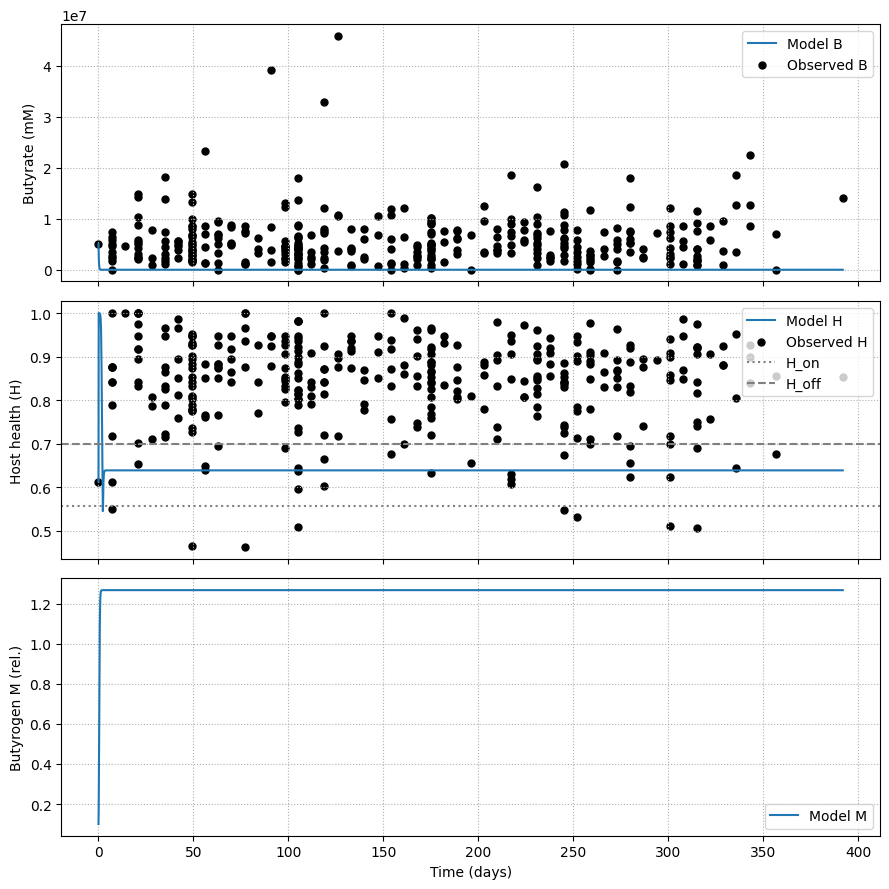

✅ Calibration complete
Fitted parameters saved to: fit_out/fitted_params.csv


In [4]:
# === step1_calibrate_hysteresis.py ===
# Calibrates (g,u,d,p_low,p_high,H_on,H_off,tau_q) for host–microbiome hysteresis model
# using combined_scfas_table_scored.csv (produced by your feature parser).
# ---------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------------------------------------
# 0) I/O and setup
# ---------------------------------------------------------------------------------------
DATA_FILE = "timeseries/combined_scfas_table_scored.csv"
OUT_DIR   = "fit_out"
os.makedirs(OUT_DIR, exist_ok=True)

# Columns
TIME_COL      = "week_number"     # use week as a temporal axis (can later convert to days/hours)
BUTYRATE_COL  = "butyrate"
HEALTH_COL    = "H_proxy_meta_smooth"   # use smoothed H proxy
M_COL         = None                     # optional: microbial abundance column (if available)

# ---------------------------------------------------------------------------------------
# 1) Load & preprocess
# ---------------------------------------------------------------------------------------
df = pd.read_csv(DATA_FILE)
# drop missing and sort
df = df.dropna(subset=[TIME_COL, BUTYRATE_COL, HEALTH_COL]).sort_values([TIME_COL])

# convert week → hours (optional, smoother integration scale)
t_obs = df[TIME_COL].values.astype(float)
t_obs = t_obs - t_obs.min()
t_obs = t_obs * 24 * 7  # hours

B_obs = df[BUTYRATE_COL].values.astype(float)
# Normalize B to model scale: 1 model unit ≈ 20 mM
B_SCALE_MM = 20.0
B_obs = B_obs / B_SCALE_MM

H_obs = df[HEALTH_COL].values.astype(float)
H_obs = np.clip(H_obs, 0, 1)

if M_COL and M_COL in df.columns:
    M_obs = np.clip(df[M_COL].values.astype(float), 1e-6, 1.0)
else:
    M_obs = None

t0, t1 = t_obs[0], t_obs[-1]
t_eval = np.linspace(t0, t1, 10 * len(t_obs))

# ---------------------------------------------------------------------------------------
# 2) Parameter bounds
# ---------------------------------------------------------------------------------------
BOUNDS = {
    "r_max":   (0.1, 0.6),
    "K_M":     (0.4, 1.5),
    "c":       (0.02, 0.25),
    "d":       (0.01, 0.5),
    "g":       (0.05, 2.0),
    "u":       (0.2, 1.2),
    "p_low":   (0.0, 0.8),
    "p_high":  (0.5, 4.0),
    "H_on":    (0.2, 0.8),
    "H_off":   (0.3, 0.95),
    "tau_q":   (0.5, 24.0)
}

def pick_bounds():
    lb = [v[0] for v in BOUNDS.values()]
    ub = [v[1] for v in BOUNDS.values()]
    return np.array(lb), np.array(ub)

# initial guess
x0 = np.array([0.32, 1.0, 0.10, 0.12, 0.5, 0.6, 0.1, 2.5, 0.55, 0.70, 4.0])

# ---------------------------------------------------------------------------------------
# 3) Model definition (M, H, B, q)
# ---------------------------------------------------------------------------------------
def microbiome_model_mem(t, y, pars):
    M, H, B, q = y
    r_max, K_M, c, d, g, u, p_low, p_high, H_on, H_off, tau_q = pars
    p_B = p_low + (p_high - p_low) * np.clip(q, 0, 1)
    dMdt = (r_max - c * p_B) * M * (1 - M / K_M)
    dHdt = g * B * (1 - H) - d * H
    dBdt = p_B * M - u * H * B
    if H < H_on:
        q_inf = 1.0
    elif H > H_off:
        q_inf = 0.0
    else:
        q_inf = q
    dqdt = (q_inf - q) / tau_q
    return [dMdt, dHdt, dBdt, dqdt]

def simulate(pars, y0):
    sol = solve_ivp(microbiome_model_mem, (t0, t1), y0, args=(pars,),
                    method="RK45", t_eval=t_eval, rtol=1e-6, atol=1e-8, max_step=0.5)
    return sol

# ---------------------------------------------------------------------------------------
# 4) Residual function for least-squares fit
# ---------------------------------------------------------------------------------------
def residuals(x):
    if x[9] <= x[8]:  # enforce H_off > H_on
        return 1e3 * np.ones(2 * len(t_obs) + 1)
    r_max, K_M, c, d, g, u, p_low, p_high, H_on, H_off, tau_q = x

    M0 = (M_obs[0] if M_obs is not None else 0.1)
    H0 = H_obs[0]
    B0 = max(B_obs[0], 1e-4)
    q0 = 1.0 if H0 < H_on else 0.0
    y0 = [M0, H0, B0, q0]

    sol = simulate(x, y0)
    Mmod = np.interp(t_obs, sol.t, sol.y[0])
    Hmod = np.interp(t_obs, sol.t, sol.y[1])
    Bmod = np.interp(t_obs, sol.t, sol.y[2])

    resB = (Bmod - B_obs)
    resH = (Hmod - H_obs)

    if M_obs is not None:
        resM = (Mmod - M_obs)
        res = np.concatenate([resB, resH, 0.5 * resM])
    else:
        res = np.concatenate([resB, resH])

    # enforce margin: p_high > p_low
    margin = max(0.0, 0.2 - (x[7] - x[6]))
    res = np.concatenate([res, [10.0 * margin]])
    return res

# ---------------------------------------------------------------------------------------
# 5) Fit optimization
# ---------------------------------------------------------------------------------------
lb, ub = pick_bounds()
fit = least_squares(residuals, x0, bounds=(lb, ub), verbose=2, max_nfev=400)

pars_hat = fit.x
names = list(BOUNDS.keys())
pd.Series(pars_hat, index=names).to_csv(os.path.join(OUT_DIR, "fitted_params.csv"))

# ---------------------------------------------------------------------------------------
# 6) Simulate using fitted parameters
# ---------------------------------------------------------------------------------------
M0 = (M_obs[0] if M_obs is not None else 0.1)
H0 = H_obs[0]
B0 = max(B_obs[0], 1e-4)
q0 = 1.0 if (H0 < pars_hat[8]) else 0.0
y0 = [M0, H0, B0, q0]
sol = solve_ivp(microbiome_model_mem, (t0, t1), y0, args=(pars_hat,),
                method="RK45", t_eval=t_eval, rtol=1e-6, atol=1e-8)

# ---------------------------------------------------------------------------------------
# 7) Diagnostic plots
# ---------------------------------------------------------------------------------------
fig, ax = plt.subplots(3, 1, figsize=(9, 9), sharex=True)

ax[0].plot(t_eval / 24.0, sol.y[2] * B_SCALE_MM, label="Model B")
ax[0].scatter(t_obs / 24.0, B_obs * B_SCALE_MM, c="k", s=25, label="Observed B")
ax[0].set_ylabel("Butyrate (mM)")
ax[0].legend()
ax[0].grid(True, ls=":")

ax[1].plot(t_eval / 24.0, sol.y[1], label="Model H")
ax[1].scatter(t_obs / 24.0, H_obs, c="k", s=25, label="Observed H")
ax[1].axhline(pars_hat[8], ls=":", c="gray", label="H_on")
ax[1].axhline(pars_hat[9], ls="--", c="gray", label="H_off")
ax[1].set_ylabel("Host health (H)")
ax[1].legend()
ax[1].grid(True, ls=":")

ax[2].plot(t_eval / 24.0, sol.y[0], label="Model M")
ax[2].set_ylabel("Butyrogen M (rel.)")
ax[2].set_xlabel("Time (days)")
ax[2].legend()
ax[2].grid(True, ls=":")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fit_diagnostics.png"), dpi=200)
plt.show()

print("✅ Calibration complete")
print("Fitted parameters saved to:", os.path.join(OUT_DIR, "fitted_params.csv"))


In [5]:
# === step1_calibrate_hysteresis_per_subject.py ===
import os
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Config
DATA_FILE = "timeseries/combined_scfas_table_scored.csv"
OUT_DIR = "fit_out_subjects"
os.makedirs(OUT_DIR, exist_ok=True)

# Column names in your scored table
TIME_COL = "week_number"
BUTYRATE_COL = "butyrate"
HEALTH_COL = "H_proxy_meta_smooth"
M_COL = None  # optional microbial abundance

# Scaling
B_SCALE_MM = 20.0  # 1 model B unit ~ 20 mM

# Parameter bounds (same as before)
BOUNDS = {
    "r_max":   (0.1, 0.6),
    "K_M":     (0.4, 1.5),
    "c":       (0.02, 0.25),
    "d":       (0.01, 0.5),
    "g":       (0.05, 2.0),
    "u":       (0.2, 1.2),
    "p_low":   (0.0, 0.8),
    "p_high":  (0.5, 4.0),
    "H_on":    (0.2, 0.8),
    "H_off":   (0.3, 0.95),
    "tau_q":   (0.5, 24.0)
}
param_names = list(BOUNDS.keys())

def pick_bounds():
    lb = [BOUNDS[n][0] for n in param_names]
    ub = [BOUNDS[n][1] for n in param_names]
    return np.array(lb), np.array(ub)

# ODE model
def microbiome_model_mem(t, y, pars):
    M, H, B, q = y
    r_max, K_M, c, d, g, u, p_low, p_high, H_on, H_off, tau_q = pars
    p_B = p_low + (p_high - p_low) * np.clip(q, 0, 1)
    dMdt = (r_max - c * p_B) * M * (1 - M / K_M)
    dHdt = g * B * (1 - H) - d * H
    dBdt = p_B * M - u * H * B
    if H < H_on:
        q_inf = 1.0
    elif H > H_off:
        q_inf = 0.0
    else:
        q_inf = q
    dqdt = (q_inf - q) / tau_q
    return [dMdt, dHdt, dBdt, dqdt]

def simulate(pars, y0, t0, t1, t_eval):
    return solve_ivp(microbiome_model_mem, (t0, t1), y0,
                     args=(pars,), method="RK45", t_eval=t_eval,
                     rtol=1e-6, atol=1e-8, max_step=0.5)

def residuals_for_subject(x, t_obs, B_obs, H_obs, M_obs):
    # enforce H_off > H_on
    if x[9] <= x[8]:
        return 1e3 * np.ones(2 * len(t_obs) + 1)
    pars = x
    M0 = (M_obs[0] if M_obs is not None else 0.1)
    H0 = H_obs[0]
    B0 = max(B_obs[0], 1e-4)
    q0 = 1.0 if (H0 < pars[8]) else 0.0
    y0 = [M0, H0, B0, q0]
    sol = simulate(pars, y0, t_obs[0], t_obs[-1], t_obs)
    Mmod = sol.y[0]
    Hmod = sol.y[1]
    Bmod = sol.y[2]
    resB = Bmod - B_obs
    resH = Hmod - H_obs
    if M_obs is not None:
        resM = Mmod - M_obs
        res = np.concatenate([resB, resH, 0.5 * resM])
    else:
        res = np.concatenate([resB, resH])
    # margin penalty
    margin = max(0.0, 0.2 - (x[7] - x[6]))
    res = np.concatenate([res, [10.0 * margin]])
    return res

# Loop per subject
df = pd.read_csv(DATA_FILE)
subjects = df["subject_id"].dropna().unique()

for sid in subjects:
    df_sub = df[df["subject_id"] == sid].dropna(subset=[TIME_COL, BUTYRATE_COL, HEALTH_COL])
    if len(df_sub) < 4:
        print(f"Skipping subject {sid}: only {len(df_sub)} valid points")
        continue

    # Prepare arrays
    t_obs = df_sub[TIME_COL].astype(float).values
    t_obs = (t_obs - t_obs.min()) * 24 * 7  # convert weeks → hours
    B_obs = df_sub[BUTYRATE_COL].astype(float).values / B_SCALE_MM
    H_obs = df_sub[HEALTH_COL].astype(float).values
    M_obs = None
    if M_COL and M_COL in df_sub.columns:
        M_obs = df_sub[M_COL].values

    t0, t1 = t_obs[0], t_obs[-1]
    t_eval = np.linspace(t0, t1, 10 * len(t_obs))

    lb, ub = pick_bounds()
    x0 = np.array([0.32, 1.0, 0.10, 0.12, 0.5, 0.6, 0.1, 2.5, 0.55, 0.70, 4.0])
    fit = least_squares(residuals_for_subject, x0,
                        bounds=(lb, ub),
                        args=(t_obs, B_obs, H_obs, M_obs),
                        verbose=1, max_nfev=200)

    pars_hat = fit.x
    out_df = pd.Series(pars_hat, index=param_names).to_frame(name="fitted").T
    outf_name = os.path.join(OUT_DIR, f"fitted_params_subject_{sid}.csv")
    out_df.to_csv(outf_name, index=False)

    # simulate with fitted
    M0 = 0.1 if M_obs is None else M_obs[0]
    H0 = H_obs[0]
    B0 = max(B_obs[0], 1e-4)
    q0 = 1.0 if (H0 < pars_hat[8]) else 0.0
    sol = simulate(pars_hat, [M0, H0, B0, q0], t0, t1, t_eval)

    # plot
    fig, axs = plt.subplots(3,1, figsize=(6,8), sharex=True)
    axs[0].plot(t_eval/24, sol.y[2]*B_SCALE_MM, label="Model B")
    axs[0].scatter(t_obs/24, B_obs*B_SCALE_MM, c="k")
    axs[0].set_ylabel("Butyrate (mM)")
    axs[1].plot(t_eval/24, sol.y[1], label="Model H")
    axs[1].scatter(t_obs/24, H_obs, c="k")
    axs[1].axhline(pars_hat[8], ls=":", c="gray")
    axs[1].axhline(pars_hat[9], ls="--", c="gray")
    axs[1].set_ylabel("H")
    axs[2].plot(t_eval/24, sol.y[0], label="Model M")
    axs[2].set_ylabel("M (butyrogen)")
    axs[2].set_xlabel("Time (days)")

    plt.suptitle(f"Subject {sid} fit")
    figname = os.path.join(OUT_DIR, f"fit_plot_subject_{sid}.png")
    plt.tight_layout()
    plt.savefig(figname, dpi=200)
    plt.close(fig)

    print(f"Finished subject {sid}, results saved in {OUT_DIR}")

print("Done all subjects.")


`gtol` termination condition is satisfied.
Function evaluations 14, initial cost 2.1145e+10, final cost 5.5000e+06, first-order optimality 0.00e+00.
Finished subject C3001, results saved in fit_out_subjects
`xtol` termination condition is satisfied.
Function evaluations 15, initial cost 4.5268e+10, final cost 4.5265e+10, first-order optimality 6.16e+05.
Finished subject C3002, results saved in fit_out_subjects
`xtol` termination condition is satisfied.
Function evaluations 26, initial cost 1.3586e+12, final cost 1.3586e+12, first-order optimality 6.36e+09.
Finished subject C3003, results saved in fit_out_subjects
`xtol` termination condition is satisfied.
Function evaluations 26, initial cost 1.0627e+11, final cost 1.0626e+11, first-order optimality 1.41e+10.
Finished subject C3004, results saved in fit_out_subjects
Skipping subject C3005: only 1 valid points
`xtol` termination condition is satisfied.
Function evaluations 19, initial cost 2.2047e+11, final cost 2.2046e+11, first-order 

ValueError: Values in `t_eval` are not within `t_span`.

In [3]:
# === step1_calibrate_hysteresis_Bonly_per_subject.py ===
# Fit the hysteretic host–microbiome model to BUTYRATE ONLY, per subject.
# - Handles duplicate timepoints (collapse by mean)
# - Robust loss + multi-start
# - Analytic scaling sB for measurement units
# Outputs:
#   fit_out_bonly_subjects/
#     fitted_params_subject_<ID>.csv
#     fit_plot_subject_<ID>.png
#   fit_out_bonly_subjects/summary_all_subjects.csv
# ----------------------------------------------------------------------
import os
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# --------------------- Config ---------------------
DATA_FILE = "timeseries/combined_scfas_table_scored.csv"
SUBJECT_COL = "subject_id"
TIME_COL = "week_number"     # weeks (float/int)
BUTYRATE_COL = "butyrate"    # observed fecal butyrate (any units)
OUT_DIR = "fit_out_bonly_subjects"
os.makedirs(OUT_DIR, exist_ok=True)

# Fitting controls
N_MULTISTART = 10
ROBUST_LOSS  = "soft_l1"     # 'linear', 'soft_l1', or 'huber'
F_SCALE      = 1.0
MAX_NFEV     = 600
MIN_POINTS   = 5             # require >= this many UNIQUE timepoints

# Parameter bounds (slightly relaxed vs earlier)
BOUNDS = {
    "r_max":   (0.1, 0.8),   # h^-1
    "K_M":     (0.4, 1.5),
    "c":       (0.02, 0.25),
    "d":       (0.01, 0.5),
    "g":       (0.05, 2.0),
    "u":       (0.2, 1.2),
    "p_low":   (0.0, 0.8),
    "p_high":  (0.5, 4.0),
    "H_on":    (0.2, 0.8),
    "H_off":   (0.3, 0.95),
    "tau_q":   (0.5, 48.0)   # hours
}
PARAMS = list(BOUNDS.keys())
LB = np.array([BOUNDS[k][0] for k in PARAMS], dtype=float)
UB = np.array([BOUNDS[k][1] for k in PARAMS], dtype=float)

# Base initial guess
X0_BASE = np.array([0.32, 1.00, 0.10, 0.12, 0.50, 0.60, 0.10, 2.50, 0.55, 0.70, 6.0], dtype=float)

rng = np.random.default_rng(42)

# --------------------- Model ---------------------
def microbiome_model_mem(t, y, pars):
    """
    y = [M, H, B, q]
    pars = [r_max, K_M, c, d, g, u, p_low, p_high, H_on, H_off, tau_q]
    """
    M, H, B, q = y
    r_max, K_M, c, d, g, u, p_low, p_high, H_on, H_off, tau_q = pars
    p_B = p_low + (p_high - p_low) * np.clip(q, 0.0, 1.0)

    dMdt = (r_max - c * p_B) * M * (1 - M / K_M)
    dHdt = g * B * (1 - H) - d * H
    dBdt = p_B * M - u * H * B

    if H < H_on:      q_inf = 1.0
    elif H > H_off:   q_inf = 0.0
    else:             q_inf = q
    dqdt = (q_inf - q) / tau_q
    return [dMdt, dHdt, dBdt, dqdt]

def simulate(pars, y0, t_eval):
    # t_eval must be strictly increasing
    return solve_ivp(microbiome_model_mem, (t_eval[0], t_eval[-1]), y0,
                     args=(pars,), method="RK45", t_eval=t_eval,
                     rtol=1e-6, atol=1e-8, max_step=0.5)

def analytic_scale(y_mod, y_obs):
    """Least-squares scale s >= 0 minimizing || s*y_mod - y_obs ||_2."""
    num = float(np.dot(y_mod, y_obs))
    den = float(np.dot(y_mod, y_mod)) + 1e-12
    return max(0.0, num / den)

def random_x0():
    x = rng.uniform(LB, UB)
    return 0.5 * x + 0.5 * np.clip(X0_BASE, LB, UB)

# --------------------- Utilities ---------------------
def collapse_time_duplicates(df_sub, time_col, y_col):
    """
    Collapse duplicate timepoints by mean value.
    Returns strictly increasing time vector in HOURS and y vector.
    """
    # group by exact time value (week_number)
    g = (df_sub[[time_col, y_col]]
         .dropna(subset=[time_col, y_col])
         .groupby(time_col, as_index=False)
         .mean()
         .sort_values(time_col))
    t_weeks = g[time_col].astype(float).values
    y = g[y_col].astype(float).values

    if len(t_weeks) < MIN_POINTS:
        return None, None

    # convert weeks -> hours and start at zero
    t_hours = (t_weeks - t_weeks.min()) * 24.0 * 7.0

    # ensure strictly increasing (unique ensured by groupby)
    if np.any(np.diff(t_hours) <= 0):
        # just in case of floating artifacts, nudge minimally
        eps = np.linspace(0, 1e-6, len(t_hours))
        t_hours = t_hours + eps

    return t_hours, y

def make_subject_plot(subject_id, t_obs, B_obs, t_eval, Bmod_scaled, sol_y, pars, out_png):
    fig, ax = plt.subplots(3,1, figsize=(7,9), sharex=True)

    # B
    ax[0].plot((t_eval - t_eval[0])/24.0, Bmod_scaled, label="Model B (scaled)")
    ax[0].scatter((t_obs - t_obs[0])/24.0, B_obs, c="k", s=25, label="Observed B")
    ax[0].set_ylabel("Butyrate (obs units)")
    ax[0].legend(); ax[0].grid(ls=":", alpha=0.6)

    # H latent
    ax[1].plot((t_eval - t_eval[0])/24.0, sol_y[1], label="Latent H")
    ax[1].axhline(pars[8], ls=":", c="gray", label="H_on")
    ax[1].axhline(pars[9], ls="--", c="gray", label="H_off")
    ax[1].set_ylabel("Host health H"); ax[1].legend(); ax[1].grid(ls=":", alpha=0.6)

    # M latent
    ax[2].plot((t_eval - t_eval[0])/24.0, sol_y[0], label="Butyrogen M")
    ax[2].set_ylabel("M (rel)"); ax[2].set_xlabel("Time (days)")
    ax[2].legend(); ax[2].grid(ls=":", alpha=0.6)

    plt.suptitle(f"Subject {subject_id} fit")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close(fig)

# --------------------- Fit one subject ---------------------
def fit_subject(df_sub, sid):
    t_obs, B_obs = collapse_time_duplicates(df_sub, TIME_COL, BUTYRATE_COL)
    if t_obs is None:
        return None  # not enough data

    # residuals depend on t_obs and B_obs captured from closure
    def residuals(x):
        # enforce H_off > H_on
        if x[9] <= x[8]:
            return 1e3 * np.ones(len(t_obs) + 1)

        # ICs (latent H)
        M0 = 0.1
        H0 = 0.7
        # seed B0 from first observation, scaled roughly to "model units"
        B0 = max(B_obs[0], 1e-6) / 20.0
        q0 = 1.0 if H0 < x[8] else 0.0
        y0 = [M0, H0, B0, q0]

        sol = simulate(x, y0, t_obs)
        if (not sol.success) or (sol.y.shape[1] != len(t_obs)):
            return 1e3 * np.ones(len(t_obs) + 1)

        Bmod = sol.y[2]
        sB = analytic_scale(Bmod, B_obs)
        resB = sB * Bmod - B_obs

        margin = max(0.0, 0.2 - (x[7] - x[6]))  # encourage p_high > p_low by >=0.2
        return np.concatenate([resB, [10.0 * margin]])

    # multistart
    candidates = [np.clip(X0_BASE, LB, UB)] + [random_x0() for _ in range(N_MULTISTART)]
    best_fit = None
    best_cost = np.inf

    for i, x0 in enumerate(candidates, 1):
        fit = least_squares(residuals, x0, bounds=(LB, UB),
                            loss=ROBUST_LOSS, f_scale=F_SCALE,
                            max_nfev=MAX_NFEV, verbose=0)
        # compute SSE on final params
        try:
            r = residuals(fit.x)
            cost = float(np.dot(r, r))
        except Exception:
            cost = np.inf

        if cost < best_cost:
            best_fit, best_cost = fit, cost

    if best_fit is None:
        return None

    # final simulate on dense grid for plotting
    pars = best_fit.x
    M0 = 0.1; H0 = 0.7; B0 = max(B_obs[0], 1e-6) / 20.0
    q0 = 1.0 if H0 < pars[8] else 0.0
    t_eval = np.linspace(t_obs[0], t_obs[-1], max(200, 10*len(t_obs)))
    sol = solve_ivp(microbiome_model_mem, (t_eval[0], t_eval[-1]), [M0,H0,B0,q0],
                    args=(pars,), method="RK45", t_eval=t_eval, rtol=1e-6, atol=1e-8)
    Bmod_dense = sol.y[2]
    # scale for plotting
    Bmod_at_obs = np.interp(t_obs, t_eval, Bmod_dense)
    sB = analytic_scale(Bmod_at_obs, B_obs)
    Bmod_scaled = sB * Bmod_dense

    # Save per-subject outputs
    ser = pd.Series(pars, index=PARAMS)
    ser["subject_id"] = sid
    ser["sB"] = sB
    ser["SSE"] = best_cost
    ser["hysteresis_width"] = ser["H_off"] - ser["H_on"]
    ser["prod_ratio"] = ser["p_high"] / (ser["p_low"] + 1e-9)

    out_csv = os.path.join(OUT_DIR, f"fitted_params_subject_{sid}.csv")
    ser.to_frame().T.to_csv(out_csv, index=False)

    out_png = os.path.join(OUT_DIR, f"fit_plot_subject_{sid}.png")
    make_subject_plot(sid, t_obs, B_obs, t_eval, Bmod_scaled, sol.y, pars, out_png)

    return ser

# --------------------- Main loop ---------------------
df = pd.read_csv(DATA_FILE)
if SUBJECT_COL not in df.columns:
    raise ValueError(f"'{SUBJECT_COL}' column not found in {DATA_FILE}")

subjects = df[SUBJECT_COL].dropna().astype(str).unique()
rows = []
for sid in subjects:
    df_sub = df[df[SUBJECT_COL] == sid].copy()
    print(f"Fitting subject {sid} ...")
    res = fit_subject(df_sub, sid)
    if res is None:
        print(f"  Skipped {sid}: not enough unique timepoints.")
        continue
    rows.append(res)

# Summary table
if rows:
    summary = pd.DataFrame(rows)
    summary = summary[["subject_id"] + PARAMS + ["sB","SSE","hysteresis_width","prod_ratio"]]
    summary_path = os.path.join(OUT_DIR, "summary_all_subjects.csv")
    summary.to_csv(summary_path, index=False)
    print(f"\n✅ Wrote summary to {summary_path}")
    print(summary[["subject_id","SSE","hysteresis_width","prod_ratio"]].sort_values("SSE").head(10))
else:
    print("No subjects fitted (insufficient data).")


Fitting subject C3001 ...


KeyboardInterrupt: 

In [12]:
# calibrate_hysteresis_from_scored_updated_v3.py
# ------------------------------------------------------------
# Robust calibration of a single-latent-producer hysteretic model
# to SCFA intensities (butyrate +/- friends) and an H proxy.
#
# Updates vs v2:
#  - Masks non-finite observations per subject when forming residuals.
#  - Replaces any remaining non-finite residuals with large finite penalties.
#  - Adds basic reporting of usable points per subject.
# ------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# ----------------- Config -----------------
INPATH  = "timeseries/combined_scfas_table_scored.csv"
OUTDIR  = "mw_fit_out"
os.makedirs(OUTDIR, exist_ok=True)

USE_H_COL  = "H_proxy_meta_smooth"   # fallback to "H_proxy_meta" if needed
USE_B_COLS = ["butyrate"]            # add "propionate" to average as composite

MIN_POINTS_PER_SUBJECT = 4
PENALTY = 1e3  # large finite penalty for any pathological case

# ----------------- Load & checks -----------------
df = pd.read_csv(INPATH)
needed = {"subject_id","sample_id"}
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

if USE_H_COL not in df.columns:
    alt = "H_proxy_meta"
    if alt in df.columns:
        print(f"[info] {USE_H_COL} not found; using {alt} instead.")
        USE_H_COL = alt
    else:
        raise ValueError("No usable H proxy column found (need H_proxy_meta_smooth or H_proxy_meta).")

for c in USE_B_COLS:
    if c not in df.columns:
        raise ValueError(f"SCFA column '{c}' not found in CSV.")

keep = ["subject_id","sample_id", USE_H_COL] + USE_B_COLS
df = df[keep].dropna(subset=["subject_id","sample_id"]).copy()

# ----------------- Time indexing -----------------
df["t_idx"] = df.groupby("subject_id").cumcount().astype(float)

# ----------------- Robust scaling (MAD) -----------------
def robust_mad_scale(x: pd.Series) -> pd.Series:
    x_valid = x.dropna().astype(float)
    if len(x_valid) == 0:
        return pd.Series(np.zeros_like(x), index=x.index)
    med = np.median(x_valid)
    mad = np.median(np.abs(x_valid - med))
    if mad < 1e-9:
        q75, q25 = np.percentile(x_valid, [75, 25])
        iqr = q75 - q25
        scale = iqr if iqr > 1e-9 else (np.std(x_valid) + 1e-9)
    else:
        scale = mad
    return (x.astype(float) - med) / (scale + 1e-9)

for c in USE_B_COLS:
    df[c + "_z"] = df.groupby("subject_id")[c].transform(robust_mad_scale)

if len(USE_B_COLS) == 1:
    df["B_obs"] = df[USE_B_COLS[0] + "_z"]
else:
    zcols = [c + "_z" for c in USE_B_COLS]
    df["B_obs"] = df[zcols].mean(axis=1)

df["H_obs"] = df[USE_H_COL].clip(0, 1)

# ----------------- Pack per-subject series -----------------
subjects = df["subject_id"].unique().tolist()
subs = []
for s in subjects:
    sub = df[df["subject_id"]==s].sort_values("t_idx")
    # Enough rows + some finite points in both channels
    if sub.shape[0] >= MIN_POINTS_PER_SUBJECT:
        Bv = sub["B_obs"].values.astype(float)
        Hv = sub["H_obs"].values.astype(float)
        if np.isfinite(Bv).sum() >= 3 and np.isfinite(Hv).sum() >= 3:
            subs.append({
                "sid": s,
                "t": sub["t_idx"].values.astype(float),
                "B": Bv,
                "H": Hv
            })

if not subs:
    raise RuntimeError("No subject has enough finite points to fit (need ≥4 rows and ≥3 finite in both B & H).")

print(f"[info] Fitting {len(subs)} subjects...")
print("[info] Per-subject usable points (finite counts):")
for S in subs[:10]:
    print(f"  - {S['sid']}: B={np.isfinite(S['B']).sum()}, H={np.isfinite(S['H']).sum()} (of {len(S['t'])})")
if len(subs) > 10:
    print("  ...")

# ----------------- Helpers -----------------
def first_finite(x: np.ndarray, default: float) -> float:
    idx = np.where(np.isfinite(x))[0]
    if len(idx) > 0:
        return float(x[idx[0]])
    return float(default)

def safe_median(x: np.ndarray, default: float) -> float:
    xf = x[np.isfinite(x)]
    return float(np.median(xf)) if len(xf) else float(default)

# ----------------- Hysteretic model -----------------
# y = [M, H, B, q]
# p = [r_max,K_M,c,d,g,u,p_low,p_high,H_on,H_off,tau_q]
def rhs(t, y, p):
    M, H, B, q = y
    r_max, K_M, c, d, g, u, pL, pH, H_on, H_off, tau = p
    pB = pL + (pH - pL)*np.clip(q, 0, 1)
    dM = (r_max - c*pB)*M*(1 - M/K_M)
    dH = g*B*(1 - H) - d*H
    dB = pB*M - u*H*B
    if H < H_on:
        q_inf = 1.0
    elif H > H_off:
        q_inf = 0.0
    else:
        q_inf = q
    dq = (q_inf - q) / tau
    return [dM, dH, dB, dq]

def simulate(ts, y0, p):
    y0 = np.array(y0, dtype=float)
    if not np.all(np.isfinite(y0)):
        T = len(ts)
        return np.vstack([np.full(T, np.nan)]*4)
    try:
        sol = solve_ivp(lambda t,y: rhs(t,y,p), (ts[0], ts[-1]), y0, t_eval=ts,
                        rtol=1e-6, atol=1e-8, max_step=0.5)
        if not sol.success:
            T = len(ts)
            return np.vstack([np.full(T, np.nan)]*4)
        return sol.y
    except Exception:
        T = len(ts)
        return np.vstack([np.full(T, np.nan)]*4)

# ----------------- Parameters -----------------
LBg = np.array([0.1, 0.4, 0.02, 0.01, 0.05, 0.2, 0.0, 0.5, 0.2, 0.3, 0.5])
UBg = np.array([0.6, 1.5, 0.25, 0.5 , 2.0 , 1.2, 0.8, 4.0, 0.8, 0.95,24.0])
x0g = np.array([0.32, 1.0, 0.10, 0.12, 0.5, 0.6, 0.1, 2.5, 0.55, 0.70, 4.0])

x0s, LBs, UBs = [], [], []
for _ in subs:
    x0s += [1.0, 0.0, 1.0]  # alpha_B, beta0_H, beta1_H
    LBs += [0.1, -0.5,  0.1]
    UBs += [5.0,  0.5,  2.0]

x0 = np.concatenate([x0g, np.array(x0s, dtype=float)])
LB = np.concatenate([LBg, np.array(LBs, dtype=float)])
UB = np.concatenate([UBg, np.array(UBs, dtype=float)])

def unpack(x):
    gpar = x[:11]
    spar = x[11:]
    triples = np.split(spar, len(subs))
    return gpar, triples

# ----------------- Residuals (masked & finite) -----------------
def residuals(x):
    gpar, triples = unpack(x)
    # enforce H_off > H_on softly
    if gpar[9] <= gpar[8]:
        return PENALTY * np.ones(10)

    res_chunks = []
    for (S,tr) in zip(subs, triples):
        alpha_B, beta0, beta1 = tr

        # Initialize from first finite or median
        H0 = float(np.clip(first_finite(S["H"], default=0.5), 0, 1))
        if not np.isfinite(H0):
            H0 = float(np.clip(safe_median(S["H"], 0.5), 0, 1))
        B0f = first_finite(S["B"], default=0.1)
        B0 = float(B0f if np.isfinite(B0f) else 0.1)
        if B0 <= 0: B0 = 0.05
        M0 = 0.1
        q0 = 1.0 if H0 < gpar[8] else 0.0
        y0 = [M0, H0, B0, q0]

        Y = simulate(S["t"], y0, gpar)  # (4, T)
        _, H, B, _ = Y

        # If integration failed, penalize with fixed-length penalties
        if np.any(~np.isfinite(H)) or np.any(~np.isfinite(B)):
            # Two channels of penalties with same length as this subject
            res_chunks.append(np.full_like(S["B"], PENALTY, dtype=float))
            res_chunks.append(np.full_like(S["H"], PENALTY, dtype=float))
            continue

        Bhat = alpha_B * B
        Hhat = np.clip(beta0 + beta1*H, 0, 1)

        # Mask out non-finite observations and predictions
        maskB = np.isfinite(S["B"]) & np.isfinite(Bhat)
        maskH = np.isfinite(S["H"]) & np.isfinite(Hhat)

        if maskB.any():
            rB = (Bhat[maskB] - S["B"][maskB])
            rB = np.nan_to_num(rB, nan=PENALTY, posinf=PENALTY, neginf=-PENALTY)
            res_chunks.append(rB)
        else:
            # if no usable B points exist, add a small penalty vector to keep shape
            res_chunks.append(np.array([PENALTY]))

        if maskH.any():
            rH = (Hhat[maskH] - S["H"][maskH])
            rH = np.nan_to_num(rH, nan=PENALTY, posinf=PENALTY, neginf=-PENALTY)
            res_chunks.append(rH)
        else:
            res_chunks.append(np.array([PENALTY]))

    res = np.concatenate(res_chunks)
    # Ensure finite residuals (for safety at x0)
    res = np.nan_to_num(res, nan=PENALTY, posinf=PENALTY, neginf=-PENALTY)
    return res

# ----------------- Fit -----------------
fit = least_squares(
    residuals, x0, bounds=(LB, UB),
    verbose=2, max_nfev=800,
    loss="soft_l1", f_scale=1.0
)
gpar_hat, triples_hat = unpack(fit.x)

param_names = ["r_max","K_M","c","d","g","u","p_low","p_high","H_on","H_off","tau_q"]
pd.Series(gpar_hat, index=param_names).to_csv(os.path.join(OUTDIR, "fitted_global_params.csv"))

pd.DataFrame(
    [{"subject_id": S["sid"], "alpha_B": tr[0], "beta0_H": tr[1], "beta1_H": tr[2]}
     for S,tr in zip(subs, triples_hat)]
).to_csv(os.path.join(OUTDIR, "fitted_subject_scales.csv"), index=False)

print("[info] Fitted global params:", dict(zip(param_names, gpar_hat)))

# ----------------- Diagnostics (first few subjects) -----------------
for S,tr in list(zip(subs, triples_hat))[:8]:
    alpha_B, beta0, beta1 = tr

    H0 = float(np.clip(first_finite(S["H"], 0.5), 0, 1))
    if not np.isfinite(H0):
        H0 = float(np.clip(safe_median(S["H"], 0.5), 0, 1))
    B0f = first_finite(S["B"], 0.1)
    B0 = float(B0f if np.isfinite(B0f) else 0.1)
    if B0 <= 0: B0 = 0.05

    y0 = [0.1, H0, B0, 1.0 if H0 < gpar_hat[8] else 0.0]
    Y = simulate(S["t"], y0, gpar_hat)
    M,H,B,q = Y
    if np.any(~np.isfinite(H)) or np.any(~np.isfinite(B)):
        continue
    Bhat = alpha_B*B
    Hhat = np.clip(beta0 + beta1*H, 0, 1)

    maskB = np.isfinite(S["B"]) & np.isfinite(Bhat)
    maskH = np.isfinite(S["H"]) & np.isfinite(Hhat)

    fig, ax = plt.subplots(2,1, figsize=(7,6), sharex=True)
    ax[0].plot(S["t"][maskB], Bhat[maskB], label="Model B (scaled)")
    ax[0].scatter(S["t"][maskB], S["B"][maskB], s=18, c="k", label="Obs B (z)")
    ax[0].set_ylabel("B intensity (scaled)")
    ax[0].legend(); ax[0].grid(True, ls=":")

    ax[1].plot(S["t"][maskH], Hhat[maskH], label="Model H")
    ax[1].scatter(S["t"][maskH], S["H"][maskH], s=18, c="k", label="H proxy")
    ax[1].axhline(gpar_hat[8], ls=":", c="gray", label="H_on")
    ax[1].axhline(gpar_hat[9], ls="--", c="gray", label="H_off")
    ax[1].set_xlabel("time index"); ax[1].set_ylabel("H")
    ax[1].legend(); ax[1].grid(True, ls=":")

    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"diag_{S['sid']}.png"), dpi=180)
    plt.close()

print("✅ Done. See outputs in:", OUTDIR)



[info] Fitting 70 subjects...
[info] Per-subject usable points (finite counts):
  - C3001: B=6, H=6 (of 6)
  - C3002: B=6, H=6 (of 6)
  - C3003: B=5, H=5 (of 5)
  - C3004: B=5, H=4 (of 5)
  - C3006: B=5, H=5 (of 5)
  - C3008: B=4, H=4 (of 4)
  - C3009: B=6, H=6 (of 6)
  - C3010: B=6, H=6 (of 6)
  - C3011: B=5, H=5 (of 5)
  - C3012: B=6, H=6 (of 6)
  ...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7545e+02                                    1.52e+06    
       1              2         3.6966e+02      5.79e+00       1.02e+00       7.39e+02    
       2              9         3.6966e+02      8.67e-06       2.11e-05       4.71e+01    
       3             10         3.6966e+02      5.98e-04       6.81e-06       6.05e+02    
       4             13         3.6966e+02      9.11e-05       7.14e-07       1.68e+02    
       5             15         3.6966e+02      1.27e-05       4.13e-08       4.71e+01    
`xtol` 

({'r_max': 0.3465643804812272,
  'K_M': 1.0703776429909533,
  'c': 0.0944240479019397,
  'd': 0.1193270743724585,
  'g': 0.5522228311225948,
  'u': 0.635394149824356,
  'p_low': 0.097690963128791,
  'p_high': 2.230457424711311,
  'H_on': 0.5500119266137443,
  'H_off': 0.9467499999999998,
  'tau_q': 3.740482435548828},
 {'n_subjects': 70,
  'alpha_B_median': 0.9874831749611788,
  'alpha_B_IQR': 0.055108537494079624,
  'beta1_H_median': 1.004690859936181,
  'beta1_H_IQR': 0.006723694343390818},
 {'H_off>H_on': True, 'p_high>p_low': True, 'r_net_at_p_high_positive': True},
 '/mnt/data/hysteresis_from_fit.png')

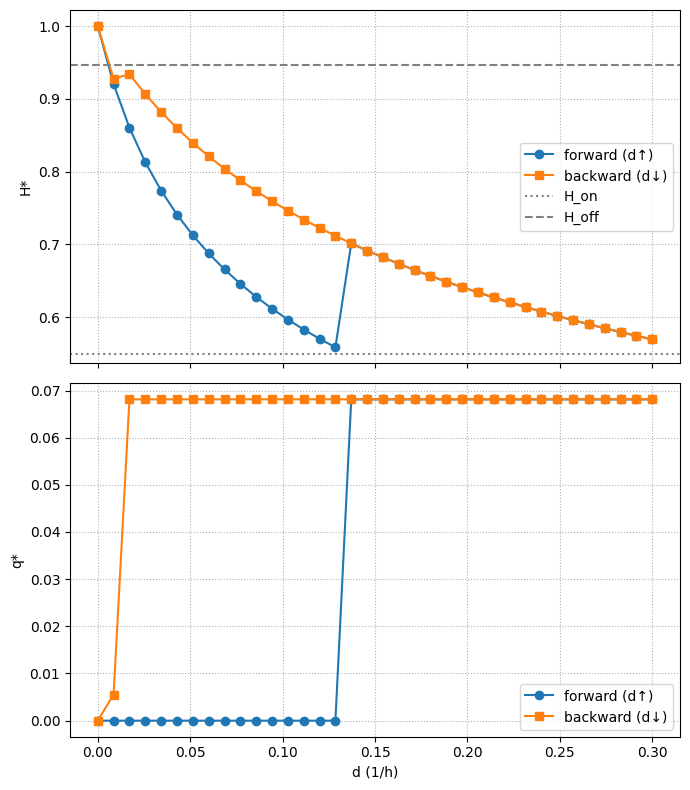

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Load fitted outputs
gpath = "mw_fit_out/fitted_global_params.csv"
spath = "mw_fit_out/fitted_subject_scales.csv"
gdf = pd.read_csv(gpath, index_col=0).squeeze("columns")
sdf = pd.read_csv(spath)

# Summaries
globals_summary = gdf.to_dict()
subject_stats = {
    "n_subjects": len(sdf),
    "alpha_B_median": float(sdf["alpha_B"].median()) if "alpha_B" in sdf.columns else None,
    "alpha_B_IQR": (
        float(sdf["alpha_B"].quantile(0.75) - sdf["alpha_B"].quantile(0.25))
        if "alpha_B" in sdf.columns else None
    ),
    "beta1_H_median": float(sdf["beta1_H"].median()) if "beta1_H" in sdf.columns else None,
    "beta1_H_IQR": (
        float(sdf["beta1_H"].quantile(0.75) - sdf["beta1_H"].quantile(0.25))
        if "beta1_H" in sdf.columns else None
    ),
}

# Quick plausibility checks
checks = {
    "H_off>H_on": bool(gdf.get("H_off", np.nan) > gdf.get("H_on", np.nan)),
    "p_high>p_low": bool(gdf.get("p_high", np.nan) > gdf.get("p_low", np.nan)),
    "r_net_at_p_high_positive": bool((gdf.get("r_max", np.nan) - gdf.get("c", np.nan)*gdf.get("p_high", np.nan)) > 0),
}

# Make a forward/backward hysteresis sweep with fitted globals
def rhs_mem(t, y, p):
    M,H,B,q = y
    r_max,K_M,c,d,g,u,pL,pH,H_on,H_off,tau = p
    pB = pL + (pH - pL)*np.clip(q,0,1)
    dM = (r_max - c*pB)*M*(1 - M/K_M)
    dH = g*B*(1 - H) - d*H
    dB = pB*M - u*H*B
    if H < H_on: qinf=1.0
    elif H > H_off: qinf=0.0
    else: qinf=q
    dq = (qinf - q)/tau
    return [dM,dH,dB,dq]

pars = [
    gdf.get("r_max", 0.32),
    gdf.get("K_M", 1.0),
    gdf.get("c", 0.10),
    None,  # d will be swept
    gdf.get("g", 0.5),
    gdf.get("u", 0.6),
    gdf.get("p_low", 0.1),
    gdf.get("p_high", 2.5),
    gdf.get("H_on", 0.55),
    gdf.get("H_off", 0.70),
    gdf.get("tau_q", 4.0),
]

def simulate_to_ss(d_val, y0, T=160):
    p = pars.copy()
    p[3] = d_val
    sol = solve_ivp(lambda t,y: rhs_mem(t,y,p), (0,T), y0, t_eval=np.linspace(0,T,600),
                    rtol=1e-6, atol=1e-8, max_step=0.5)
    return sol.y[:,-1], sol

d_grid = np.linspace(0.00, 0.30, 36)
y = np.array([0.1, 0.7, 0.1, 0.0], dtype=float)

fwd = []
for d in d_grid:
    y, _ = simulate_to_ss(d, y, T=160)
    fwd.append((d, *y))

bwd = []
for d in d_grid[::-1]:
    y, _ = simulate_to_ss(d, y, T=160)
    bwd.append((d, *y))

fwd = pd.DataFrame(fwd, columns=["d","M","H","B","q"])
bwd = pd.DataFrame(bwd, columns=["d","M","H","B","q"])

# Plot hysteresis (if present)
fig, ax = plt.subplots(2,1, figsize=(7,8), sharex=True)
ax[0].plot(fwd["d"], fwd["H"], marker="o", label="forward (d↑)")
ax[0].plot(bwd["d"], bwd["H"], marker="s", label="backward (d↓)")
ax[0].axhline(gdf.get("H_on", np.nan), ls=":", c="gray", label="H_on")
ax[0].axhline(gdf.get("H_off", np.nan), ls="--", c="gray", label="H_off")
ax[0].set_ylabel("H*"); ax[0].grid(True, ls=":"); ax[0].legend()

ax[1].plot(fwd["d"], fwd["q"], marker="o", label="forward (d↑)")
ax[1].plot(bwd["d"], bwd["q"], marker="s", label="backward (d↓)")
ax[1].set_xlabel("d (1/h)"); ax[1].set_ylabel("q*"); ax[1].grid(True, ls=":"); ax[1].legend()

plt.tight_layout()
# out_plot = "/mnt/data/hysteresis_from_fit.png"
# plt.savefig(out_plot, dpi=180)

globals_summary, subject_stats, checks, out_plot


## other

In [ ]:
NOOOOOOOOOOOOOOOOO USEEEEEEEEEEEE









# JUPYTER CELL 3 — feature engineering (optional)

def build_features(meta: pd.DataFrame) -> pd.DataFrame:
    freq_map = {
        "No, I did not consume these products in the last 7 days": 0,
        "Within the past 4 to 7 days": 1,
        "Within the past 2 to 3 days": 2,
        "Yesterday, 1 to 2 times": 3,
        "Yesterday, 3 or more times": 4,
    }
    def score(col): return meta[col].map(freq_map).fillna(0)

    fiber_cols = [
        "Whole_grains_(wheat,_oats,_brown_rice,_rye,_quinoa,_wheat_bread,_wheat_pasta)",
        "Beans_(tofu,_soy,_soy_burgers,_lentils,_Mexican_beans,_lima_beans_etc)",
        "Fruits_(no_juice)_(Apples,_raisins,_bananas,_oranges,_strawberries,_blueberries",
        "Vegetables_(salad,_tomatoes,_onions,_greens,_carrots,_peppers,_green_beans,_etc)",
    ]
    meta["fiber_score"] = sum(score(c) for c in fiber_cols if c in meta.columns)

    fer_cols = ["Yogurt_or_other_foods_containing_active_bacterial_cultures_(kefir,_sauerkraut)"]
    probiotic = meta["Probiotic"].map(freq_map).fillna(0) if "Probiotic" in meta.columns else 0
    meta["fermented_score"] = sum(score(c) for c in fer_cols if c in meta.columns) + probiotic

    neg_cols = [
        "Processed_meat_(other_red_or_white_meat_such_as_lunch_meat,_ham,_salami,_bologna",
        "Red_meat_(beef,_hamburger,_pork,_lamb)"
    ]
    meta["procmeat_score"] = sum(score(c) for c in neg_cols if c in meta.columns)

    # meds/procedures → binary flags
    bin_cols = [
        "Antibiotics",
        "Immunosuppressants_(e.g._oral_corticosteroids)",
        "Chemotherapy",
        "In_the_past_2_weeks,_have_you_been_hospitalized?",
        "In_the_past_2_weeks,_have_you_used_an_oral_contrast?",
        "In_the_past_2_weeks,_have_you_undergone_a_colonoscopy_or_other_procedure",
    ]
    for k in bin_cols:
        if k in meta.columns:
            meta[k+"_bin"] = meta[k].str.strip().str.lower().map({"yes":1,"no":0}).fillna(0).astype(int)

    # very rough HBI proxy (if available)
    hbi_map_wellbeing = {"Very well":0,"Well":1,"Slightly below par":2,"Poor":3,"Terrible":4}
    if "General_wellbeing" in meta.columns:
        meta["HBI_gw"] = meta["General_wellbeing"].map(hbi_map_wellbeing)
    hbi_map_pain = {"None":0,"Mild":1,"Moderate":2,"Severe":3}
    if "Abdominal_pain" in meta.columns:
        meta["HBI_pain"] = meta["Abdominal_pain"].map(hbi_map_pain)
    if "Number_of_liquid_or_very_soft_stools_in_the_past_24_hours:" in meta.columns:
        meta["HBI_stools"] = pd.to_numeric(meta["Number_of_liquid_or_very_soft_stools_in_the_past_24_hours:"], errors="coerce")

    h_cols = [c for c in ["HBI_gw","HBI_pain","HBI_stools"] if c in meta.columns]
    if h_cols:
        h_raw = meta[h_cols].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)
        meta["H_proxy"] = 1 - (h_raw - h_raw.min())/(h_raw.max()-h_raw.min() + 1e-9)

    keep = ["subject_id","local_sample_id","time_hr","fiber_score","fermented_score",
            "procmeat_score","H_proxy"] + [c for c in meta.columns if c.endswith("_bin")]

    return meta[[c for c in keep if c in meta.columns]].copy()

features_df = build_features(meta_df.copy())
features_df.to_csv(OUT_FEATURES, index=False)
features_df.head(5)


In [ ]:
# JUPYTER CELL 4 — try to emit butyrate_timeseries.csv from THIS file
# (AN001515 often lacks butyrate; do this on AN001514 to get it.)

def is_butyrate(name: str) -> bool:
    s = str(name).strip().lower().replace(" ","").replace("-","")
    return s in {"butyrate","butyricacid","butanoate","butanoicacid"}

mask = long_df["metabolite_name"].map(is_butyrate)
if mask.any():
    b = (long_df.loc[mask, ["subject_id","local_sample_id","time_hr","intensity"]]
         .rename(columns={"intensity":"butyrate_intensity"})
         .sort_values(["subject_id","time_hr"]))
    b.to_csv(OUT_BUTYRATE_TS, index=False)
    print("Wrote", OUT_BUTYRATE_TS, "with", len(b), "rows.")
else:
    print("No butyrate in this file. Parse AN001514 with the same cells to produce", OUT_BUTYRATE_TS)


In [ ]:
# JUPYTER CELL 5 — ODE calibration and hysteresis

@dataclass
class Params:
    r_max: float = 0.4
    K_M:   float = 1.0
    c:     float = 0.15
    d:     float = 0.10
    K_H:   float = 1.0
    g:     float = 0.5
    u:     float = 0.6

def rhs(t, y, pB, p: Params):
    M, H, B = y
    dM = (p.r_max - p.c*pB) * M * (1 - M/p.K_M)
    dH = p.g * B * (1 - H/p.K_H) - p.d * H
    dB = pB * M - p.u * H * B
    return [dM, dH, dB]

def simulate(p: Params, pB: float, y0=(0.2,0.7,0.5), T=200.0, n=1200):
    t = np.linspace(0, T, n)
    sol = solve_ivp(rhs, (0,T), y0, args=(pB,p), t_eval=t, rtol=1e-7, atol=1e-9)
    return t, sol.y

def fit_subject(df_subj: pd.DataFrame, init: Params) -> Tuple[Params, float, float]:
    # expects columns: time_hr and either butyrate_mM or butyrate_intensity
    df_subj = df_subj.sort_values("time_hr")
    use_mM = "butyrate_mM" in df_subj.columns
    y_obs = df_subj["butyrate_mM" if use_mM else "butyrate_intensity"].to_numpy()
    t_obs = df_subj["time_hr"].to_numpy()
    t_rel = t_obs - t_obs.min()
    t_grid = np.linspace(0, max(48.0, t_rel.max()), max(400, 10*len(t_rel)))

    x0 = np.array([init.g, init.u, init.d, 1.0, 1.0])  # g,u,d,pB,sB
    lb = [0.01, 0.05, 0.01, 0.05, 1e-6]
    ub = [5.0,  5.0,  1.0,  5.0,  1e6]
    if use_mM:
        x0 = x0[:-1]; lb = lb[:-1]; ub = ub[:-1]

    def resid(x):
        if use_mM:
            g,u,d,pB = x; sB = 1.0
        else:
            g,u,d,pB,sB = x
        p = Params(r_max=init.r_max, K_M=init.K_M, c=init.c, d=d, K_H=init.K_H, g=g, u=u)
        y0 = (0.2, 0.7, max(0.05, y_obs[0]/sB))
        _, Y = simulate(p, pB, y0=y0, T=t_grid[-1], n=len(t_grid))
        B_model = np.interp(t_rel, t_grid, Y[2])
        return sB*B_model - y_obs

    fit = least_squares(resid, x0, bounds=(lb,ub), xtol=1e-10, ftol=1e-10)
    if use_mM:
        g,u,d,pB = fit.x; sB = 1.0
    else:
        g,u,d,pB,sB = fit.x
    est = Params(r_max=init.r_max, K_M=init.K_M, c=init.c, d=d, K_H=init.K_H, g=g, u=u)
    return est, pB, sB

def steady(p: Params, pB: float, y0=(0.2,0.6,0.3), T=2000):
    _, Y = simulate(p, pB, y0=y0, T=T, n=2000)
    return Y[:, -1]

def hysteresis(p: Params, pB_min=0.05, pB_max=3.0, steps=35):
    p_up = np.linspace(pB_min, pB_max, steps)
    p_dn = np.linspace(pB_max, pB_min, steps)
    y0 = (0.2,0.6,0.3)
    fwd = []
    for v in p_up:
        y0 = steady(p, v, y0=y0)
        fwd.append([v, *y0])
    y0 = fwd[-1][1:]
    bwd = []
    for v in p_dn:
        y0 = steady(p, v, y0=y0)
        bwd.append([v, *y0])
    fwd = pd.DataFrame(fwd, columns=["p_B","M","H","B"])
    bwd = pd.DataFrame(bwd, columns=["p_B","M","H","B"])
    return fwd, bwd

def run_hysteresis(timeseries_csv: str, subject_id=None):
    df = pd.read_csv(timeseries_csv)
    if subject_id is not None and "subject_id" in df.columns:
        df = df[df["subject_id"]==subject_id].copy()
    use_col = "butyrate_mM" if "butyrate_mM" in df.columns else "butyrate_intensity"
    df = df.dropna(subset=["time_hr", use_col]).sort_values("time_hr")

    init = Params()
    est, pB_hat, sB = fit_subject(df[["time_hr", use_col]], init)
    print(f"Fit: g={est.g:.3f}, u={est.u:.3f}, d={est.d:.3f}, pB={pB_hat:.3f}, scale={sB:.3g}")

    # fit plot
    t_eval = np.linspace(0, df["time_hr"].max(), 400)
    y0 = (0.2, 0.7, max(0.05, df[use_col].iloc[0]/sB))
    t, Y = simulate(est, pB_hat, y0=y0, T=t_eval[-1], n=len(t_eval))
    plt.figure(figsize=(7,4.5))
    plt.plot(df["time_hr"], df[use_col], "o", label="Observed butyrate")
    plt.plot(t, sB*Y[2], "-", label="Model fit")
    plt.xlabel("Time (hr)"); plt.ylabel("Butyrate" + (" (mM)" if use_col=="butyrate_mM" else " (intensity)"))
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # hysteresis
    fwd, bwd = hysteresis(est, pB_min=max(0.05, 0.1*pB_hat), pB_max=max(0.5, 3.0*pB_hat), steps=35)
    fwd.to_csv("hysteresis_forward.csv", index=False)
    bwd.to_csv("hysteresis_backward.csv", index=False)
    plt.figure(figsize=(6.5,4.5))
    plt.plot(fwd["p_B"], fwd["B"], label="forward")
    plt.plot(bwd["p_B"], bwd["B"], label="backward")
    plt.xlabel("p_B (production driver)"); plt.ylabel("Steady-state B (model units)")
    plt.title("Hysteresis loop"); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
    print("Saved: hysteresis_forward.csv, hysteresis_backward.csv")

# EXAMPLE:
# run_hysteresis("butyrate_timeseries.csv", subject_id="C3001")
